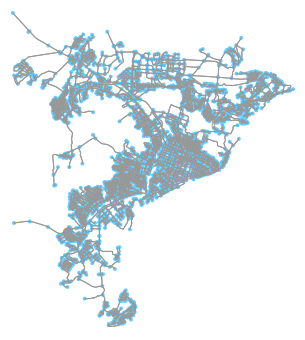

In [388]:
import osmnx as ox
import networkx as nx
from pprint import pprint
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import osmapi as osm

#Api по id получить координаты и другую инфн
api = osm.OsmApi()
#no = api.NodeGet(6567460866)

place = {'city' : 'Saratov',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive')

#Рисуем граф дорог
fig, ax = ox.plot_graph(G)

In [389]:
#Словарь расстояний между смежными перекрестками
a = G.adj
dictionary = {}
dict_name = {}

for key, value in a.items():
    for key_a, value_a in value.items():
        if key in dictionary:
            dictionary[key].append({key_a : value_a[0]['length']})
        else:
            dictionary[key] = [{key_a : value_a[0]['length']}]

nodes_list = list(G.nodes())

In [390]:
#Достаем все здания
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

#Из первых 10000 выбираем 10 больниц и 100 домов
hospital = []
apartments = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key, value in build.items():
    if value == 'hospital':
        hospital.append(key)
    elif value == 'apartments':
        apartments.append(key)

random.shuffle(hospitals)
random.shuffle(apartments)

hospitals_all = hospitals
apartments_all = apartments
hospitals = hospital[:3]
apartments = apartments[1:11]

print(hospital)
print(apartments)


[86350946, 86350950, 86350953, 86351386, 86351393, 86968075, 87065291, 87183858, 87183860, 90944648, 90944650, 90944666, 90944690, 90944692, 91640238, 91640250, 91640264, 91640299, 92969088, 103132550]
[87183831, 91369873, 88725762, 86491812, 87241321, 86581278, 86431135, 89174816, 91667843, 92043639]


In [391]:
#Находим ближайшие узлы до домов и больниц
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}

print('Больницы')
for i in hospitals:
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node
    print(i, nearest_node)
print('------------------')
print('Апартаменты')
for i in apartments:
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    print(i, nearest_node)


Больницы
86350946 349310231
86350950 349310231
86350953 341817337
------------------
Апартаменты
87183831 702952833
91369873 1068531667
88725762 1733407310
86491812 3655853417
87241321 360695157
86581278 1252641560
86431135 363237123
89174816 343723862
91667843 345849047
92043639 1069250119


In [392]:
#Матрица смежности графа
G_pd = nx.to_pandas_adjacency(G)
G_pd = G_pd.values
G_size = len(G_pd)
INF = 10**10

#Заполнение матрицы смежности с учетом условий взвешенного расстояния
for i in range(G_size):
    for j in range(G_size):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]

            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random.random() + 1

            G_pd[i][j] = distance * weight

        elif G_pd[i][j] == 0:
            G_pd[i][j] = INF

#Создаем словарь {id узла}: {его index в списке узлов}
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i] = index

In [393]:
#Алгоритм Дейкстры
def Dijkstra(N, S, matrix):
    valid = [True]*N
    weight = [INF]*N
    p = [INF] * N
    p[S] = -1
    weight[S] = 0
    for i in range(N):
        min_weight = INF + 1
        ID_min_weight = -1
        for j in range(N):
            if valid[j] and weight[j] < min_weight:
                min_weight = weight[j]
                ID_min_weight = j
        for z in range(N):
            if weight[ID_min_weight] + matrix[ID_min_weight][z] < weight[z]:
                weight[z] = weight[ID_min_weight] + matrix[ID_min_weight][z]
                p[z] = ID_min_weight
        valid[ID_min_weight] = False
    return weight, p

In [394]:
#1

#Для каждого узла(дома) запускаем алгоритм Д.
from_apartments = {}
from_hospitals = {}
from_apartments_p = {}
from_hospitals_p = {}
print(apartments_dict)
for key, value in apartments_dict.items():
    start = nodes_numbers[value]
    weight, p = Dijkstra(G_size, start, G_pd)

    from_apartments[key] = weight
    from_apartments_p[key] = p
    
#Для каждого узла(больници) запускаем алгоритм Д.
for key, value in hospitals_dict.items():
    start = nodes_numbers[value]
    weight, p = Dijkstra(G_size, start, G_pd)

    from_hospitals[key] = weight
    from_hospitals_p[key] = p

X = 5000
object_there = {}
object_back = {}
object_there_back = {}

{87183831: 702952833, 91369873: 1068531667, 88725762: 1733407310, 86491812: 3655853417, 87241321: 360695157, 86581278: 1252641560, 86431135: 363237123, 89174816: 343723862, 91667843: 345849047, 92043639: 1069250119}


In [395]:
#Вычисляем от каждого узла(дома) расстояние до ближайшей больници
for key_from, value_from in from_apartments.items():
    min_weight = INF
    min_index = -1
    weight_size = len(value_from)

    node_from = apartments_dict[key_from]
    index_from = nodes_numbers[node_from]

    for key_to, value_to in from_hospitals.items():
        node_to = hospitals_dict[key_to]
        index_to = nodes_numbers[node_to]

        #1a
        if value_from[index_to] < min_weight:
            min_weight = value_from[index_to]
            min_index = key_to

        #1b
        if value_from[index_to] < X:
            if key_from in object_there:
                object_there[key_from].append(key_to)
            else:
                object_there[key_from] = [key_to]

    print("min lenght from ", key_from, " to ", min_index, " is ", min_weight)

min lenght from  87183831  to  86350953  is  952.6189999999999
min lenght from  91369873  to  86350953  is  17560.196999999996
min lenght from  88725762  to  86350953  is  2396.061
min lenght from  86491812  to  86350953  is  8116.319
min lenght from  87241321  to  86350953  is  5369.379000000001
min lenght from  86581278  to  86350953  is  11506.436999999998
min lenght from  86431135  to  86350953  is  8661.149
min lenght from  89174816  to  86350953  is  3826.4850000000006
min lenght from  91667843  to  86350953  is  10835.972000000002
min lenght from  92043639  to  86350953  is  5906.814


In [396]:
#Вычисляем от каждого узла(больницы) расстояние до ближайшего дома
mi_to = INF
mi_index_to = -1
for key_from, value_from in from_hospitals.items():
    min_weight = INF
    min_index = -1
    weight_size = len(value_from)

    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        #1a
        if value_from[index_to] < min_weight:
            min_weight = value_from[index_to]
            min_index = key_to

        #1b
        if value_from[index_to] < X:
            if key_from in object_back:
                object_back[key_from].append(key_to)
            else:
                object_back[key_from] = [key_to]

    print("min lenght from ", key_from, " to ", min_index, " is ", min_weight)

min lenght from  86350946  to  87183831  is  1719.3726278051918
min lenght from  86350950  to  87183831  is  1719.3726278051918
min lenght from  86350953  to  87183831  is  1375.7873486290976


In [397]:
#Находим больницу расстояние до которой и обратно минимально
for key_from, value_from in from_apartments.items():
    node_from = apartments_dict[key_from]
    index_from = nodes_numbers[node_from]

    min_path = INF
    min_index = -1
    for key_to, value_to in from_hospitals.items():
        node_to = hospitals_dict[key_to]
        index_to = nodes_numbers[node_to]

        w = value_from[index_to] + value_to[index_from]

        #1a
        if w < min_path:
            min_path = w
            min_index = key_to

        #1b
        if value_from[index_to] < X:
            if key_from in object_there_back:
                object_there_back[key_from].append(key_to)
            else:
                object_there_back[key_from] = [key_to]

    print("min path from ", key_from, " to ", min_index, " is ", min_path)


min path from  87183831  to  86350953  is  2328.4063486290975
min path from  91369873  to  86350953  is  35135.38803379415
min path from  88725762  to  86350953  is  4857.332348629097
min path from  86491812  to  86350953  is  16211.860348629098
min path from  87241321  to  86350953  is  10738.250348629099
min path from  86581278  to  86350953  is  24273.682348629096
min path from  86431135  to  86350953  is  16806.314348629097
min path from  89174816  to  86350953  is  7765.305348629097
min path from  91667843  to  86350953  is  21963.384348629097
min path from  92043639  to  86350953  is  11537.631348629096


In [398]:
#2.2
#Вычисляем от каждого узла(больницы) расстояние до ближайшего дома
weight_min_there = INF
weight_min_back = INF
weight_min_there_back = INF
index_min_there = -1
index_min_back = -1
index_min_there_back = -1

for key_from, value_from in from_hospitals.items():
    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    weight_there = 0
    weight_back = 0
    weight_there_back = 0
    index_there = -1
    index_back = -1
    index_there_back = -1

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        if value_to[index_from] > weight_there:
            weight_there = value_to[index_from]
            index_there = key_from

        if value_from[index_to] > weight_back:
            weight_back = value_from[index_to]
            index_back = key_from

        w = value_to[index_from] + value_from[index_to]

        if w > weight_there_back:
            weight_there_back = w
            index_there_back = key_from

    if weight_there < weight_min_there:
        weight_min_there = weight_there
        index_min_there = index_there
    
    if weight_back < weight_min_back:
        weight_min_back = weight_back
        index_min_back = index_back

    if weight_there_back < weight_min_there_back:
        weight_min_there_back = weight_there_back
        index_min_there_back = index_there_back

print("there: ", index_min_there, weight_min_there)
print("back: ", index_min_back, weight_min_back)
print("there and back: ", index_min_there_back, weight_there_back)


there:  86350953 17560.196999999996
back:  86350953 17575.19103379416
there and back:  86350953 35135.38803379415


In [399]:
#2.3
#Больница до которой сумма расстояний до всех домов из выборки минимальна
min_s = INF
min_index = -1
for key_from, value_from in from_hospitals.items():
    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    s = 0

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        s += value_from[index_to]

    if s < min_s:
        min_s = s
        min_index = key_from

print("min sum: ", key_from, min_s)


min sum:  86350953 76486.12317145603


In [400]:
#2.4
#Дерево кратчайших путей минимально
s_min = INF
index_min = -1
for key_from, value_from in from_hospitals_p.items():
    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    s = 0

    used = [0] * G_size

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        v = index_to
        start = index_from
        while v != start:
            if used[v] == 0:
                used[v] = 1
                s += G_pd[value_from[v]][v]
            v = value_from[v]

    if s < s_min:
        s_min = s
        index_min = key_from

print("min tree: ", index_min, s_min)

min tree:  86350953 50136.71538242324


In [401]:
#3.1
#Дерево кратчайших путей
hospitals_list = list(hospitals)
KEY = hospitals_list[random.randint(0, 2)]
node_from = hospitals_dict[KEY]
index_from = nodes_numbers[node_from]

value_from = from_hospitals_p[KEY]

s_tree = 0
s_paths = 0

used = [0] * G_size

for key_to, value_to in from_apartments.items():
    node_to = apartments_dict[key_to]
    index_to = nodes_numbers[node_to]

    v = index_to
    start = index_from
    while v != start:
        if used[v] == 0:
            used[v] = 1
            s_tree += G_pd[value_from[v]][v]
        s_paths += G_pd[value_from[v]][v]
        
        v = value_from[v]

print("weight tree: ", KEY, s_tree)
print("weight paths: ", KEY, s_paths)

weight tree:  86350950 50996.58155244445
weight paths:  86350950 79367.73657488605


(10, 2)
[[45.9825177 51.5398878]
 [45.8502068 51.5918041]
 [46.0114962 51.5345821]
 [45.951068  51.5833187]
 [45.9780099 51.5670365]
 [46.010195  51.6123106]
 [45.9703906 51.5899672]
 [46.028867  51.5293422]
 [45.9982598 51.6020052]
 [45.9852175 51.5115711]]


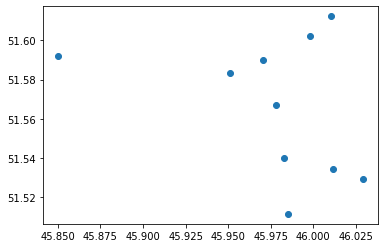

[[5.00000000e+00 8.00000000e+00 1.57686483e-02 2.00000000e+00]
 [2.00000000e+00 7.00000000e+00 1.81439038e-02 2.00000000e+00]
 [3.00000000e+00 6.00000000e+00 2.04344176e-02 2.00000000e+00]
 [0.00000000e+00 4.00000000e+00 2.75203956e-02 2.00000000e+00]
 [9.00000000e+00 1.10000000e+01 4.67373257e-02 3.00000000e+00]
 [1.20000000e+01 1.30000000e+01 5.44529555e-02 4.00000000e+00]
 [1.00000000e+01 1.50000000e+01 8.18873574e-02 6.00000000e+00]
 [1.40000000e+01 1.60000000e+01 1.26424101e-01 9.00000000e+00]
 [1.00000000e+00 1.70000000e+01 1.92281515e-01 1.00000000e+01]]


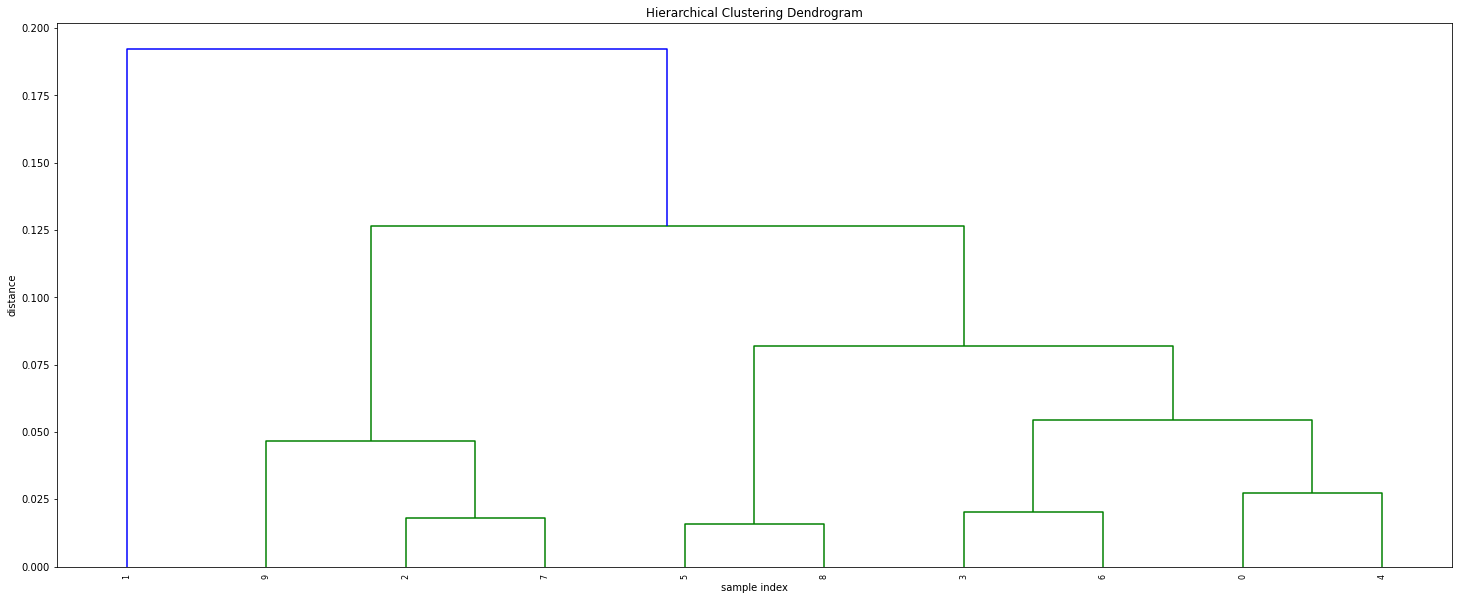

In [402]:
#3.2
from scipy.cluster.hierarchy import dendrogram, linkage

a = []

for key in apartments:
    node = apartments_dict[key]
    a.append([G.nodes[node]['x'], G.nodes[node]['y']])    
    
X = np.array(a)

print(X.shape)
print(X)
#Удаляем точку по приколу - она лежит слишком далеко и график будет плохим
#X = X[1:]
plt.scatter(X[:,0], X[:,1])
plt.show()

Z = linkage(X, 'ward')

print(Z)

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

[2 3 1 2 2 2 2 1 2 1]
{2: array([[45.9825177, 51.5398878],
       [45.951068 , 51.5833187],
       [45.9780099, 51.5670365],
       [46.010195 , 51.6123106],
       [45.9703906, 51.5899672],
       [45.9982598, 51.6020052]]), 3: array([[45.8502068, 51.5918041]]), 1: array([[46.0114962, 51.5345821],
       [46.028867 , 51.5293422],
       [45.9852175, 51.5115711]])}
{2: [0, 3, 4, 5, 6, 8], 3: [1], 1: [2, 7, 9]}
{2: [45.98174016666667, 51.582421000000004], 3: [45.8502068, 51.5918041], 1: [46.0085269, 51.52516513333333]}
{2: 342439998, 3: 1068531667, 1: 1260647181}


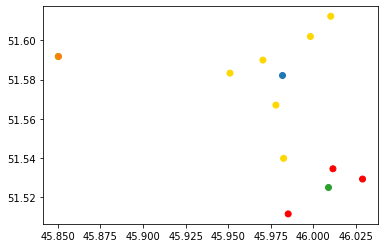

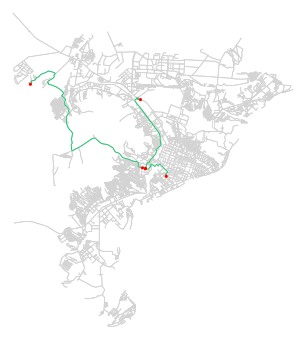

apart [87183831, 91369873, 88725762, 86491812, 87241321, 86581278, 86431135, 89174816, 91667843, 92043639]
{87183831: 702952833, 91369873: 1068531667, 88725762: 1733407310, 86491812: 3655853417, 87241321: 360695157, 86581278: 1252641560, 86431135: 363237123, 89174816: 343723862, 91667843: 345849047, 92043639: 1069250119}
[0, 3, 4, 5, 6, 8]
87183831 702952833 5026
86491812 3655853417 3712
87241321 360695157 548
86581278 1252641560 1209
86431135 363237123 1585
91667843 345849047 5592
[1]
91369873 1068531667 5867
[2, 7, 9]
88725762 1733407310 4692
89174816 343723862 1608
92043639 1069250119 5066


IndexError: index 0 is out of bounds for axis 0 with size 0

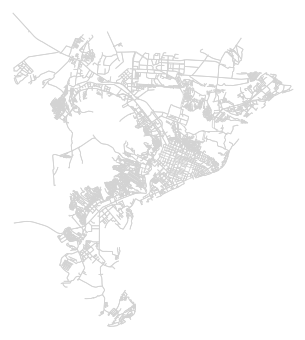

In [404]:
from scipy.cluster.hierarchy import fcluster

def get_path(start, finish, p):
    path = []
    while finish != start:
        path.append(nodes_list[finish])
        finish = p[finish]
    
    path.reverse()
    return path

def centr(X, Z, k, hosp_ind):
    clusters = fcluster(Z, k, criterion='maxclust')
    
    print(clusters)
    
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent %colors
    
    clusters_us = {}
    clusters_us_id = {}
    for i in range(len(clusters)):
        j = clusters[i]
        if j in clusters_us:
            clusters_us[j].append(X[i])
            clusters_us_id[j].append(i)
        else:
            clusters_us[j] = [X[i]]
            clusters_us_id[j] = [i]
            
    for key, value in clusters_us.items():
        clusters_us[key] = np.array(value)
    print(clusters_us)
    print(clusters_us_id)
    
    #a
    centroids = {}
    centroids_node = {}
    for key, value in clusters_us.items():
        n = len(value)
        x = sum(value[:, 0]) / n
        y = sum(value[:, 1]) / n
        centroids[key] = [x, y]
        
        centroids_node[key] = ox.get_nearest_node(G, (y, x))
        plt.scatter(x, y)
    
    print(centroids)
    print(centroids_node)
        
    plt.show()
    
    #b
    node_from = hospitals_dict[hosp_ind]
    index_from = nodes_numbers[node_from]
    weight, p = Dijkstra(G_size, index_from, G_pd)
    
    routes = []
    for key, value in centroids_node.items():
        v = nodes_numbers[value]
        
        path = get_path(index_from, v, p)
        routes.append(np.array(path))
    
    fig, ax = ox.plot_graph_routes(G, routes,
                                   node_alpha=0, edge_color='lightgray', edge_alpha=1, edge_linewidth=0.8,
                                   route_color='#00cc66', route_linewidth=0.8, route_alpha=1,
                                   orig_dest_node_size=10, orig_dest_node_color='r', orig_dest_node_alpha=1)
    
    name = 'obj_to_centroids'
    ox.plot.save_and_show(fig, ax, save=True, show=False, filename=name, file_format='png', close=True, 
                          dpi=500, axis_off=True)
    
    
    #c
    routes = []
    print("apart", apartments)
    print(apartments_dict)
    
    for key, value in clusters_us_id.items():
        cent_node = centroids_node[key]
        start = nodes_numbers[cent_node]
        weight, p = Dijkstra(G_size, start, G_pd)
        
        #route = nx.shortest_path(G, node_from, cent_node, weight='length')
        print(value)
        for i in value:
            print(apartments[i], apartments_dict[apartments[i]], nodes_numbers[apartments_dict[apartments[i]]])
            path = get_path(start, nodes_numbers[apartments_dict[apartments[i]]], p)
            routes.append(np.array(path))
        
        #rc = ['r'] * (len(route) - 1)
        #nc = ['r', 'r']
    fig, ax = ox.plot_graph_routes(G, routes,
                                   node_alpha=0, edge_color='lightgray', edge_alpha=1, edge_linewidth=0.8,
                                   route_color='#00cc66', route_linewidth=0.8, route_alpha=1,
                                   orig_dest_node_size=10, orig_dest_node_color='r', orig_dest_node_alpha=1)

    name=str(key)
    ox.plot.save_and_show(fig, ax, save=True, show=False, filename=name, file_format='png', close=True, 
                          dpi=500, axis_off=True)
        

k = 3
#print(G.nodes[421435796]['x'], G.nodes[421435796]['y'])
centr(X, Z, k, KEY)

In [ ]:
#тестирование Дэйкстры
